In [1]:
!pip install demjson

     |████████████████████████████████| 133kB 911kB/s 
  Created wheel for demjson: filename=demjson-2.2.4-cp36-none-any.whl size=73546 sha256=959fc83dc72326b18a8dd45851749dde460e71b2c481875a27e9cfd7bd3b256f
  Stored in directory: /root/.cache/pip/wheels/c5/d2/ab/a54fb5ea53ac3badba098160e8452fa126a51febda80440ded
Successfully built demjson


![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from demjson import decode
import re
from datetime import datetime
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
12384,id_5480,London,['Mediterranean'],5489.0,$$ - $$$,12.0,"[['Lazy evening out', 'Amazing'], ['12/07/2017...",/Restaurant_Review-g186338-d10903275-Reviews-V...,d10903275,1,4.5
23716,id_4721,Rome,"['Japanese', 'Sushi']",4722.0,NaN,142.0,"[[], []]",/Restaurant_Review-g187791-d2733102-Reviews-Xi...,d2733102,1,3.5
16828,id_4175,Madrid,"['Bar', 'Pub']",4177.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187514-d4436466-Reviews-Ja...,d4436466,1,5.0
15499,id_503,Hamburg,"['Pizza', 'Italian', 'Mediterranean', 'Vegetar...",504.0,$$ - $$$,117.0,"[['Fast service - excellent food!', 'Interesti...",/Restaurant_Review-g187331-d1039115-Reviews-Al...,d1039115,1,4.0
42797,id_439,Luxembourg,['French'],440.0,$$ - $$$,24.0,"[['Missed opportunity', 'Brigitte Brasserie / ...",/Restaurant_Review-g190356-d9857865-Reviews-Br...,d9857865,1,3.5


In [15]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [16]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [17]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [18]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [19]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [20]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [21]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
8991,id_8991,"['Chinese', 'Asian', 'Vegetarian Friendly', 'V...",543.0,$$ - $$$,673.0,"[['Meeting', 'Well done'], ['01/08/2018', '01/...",/Restaurant_Review-g186338-d7973895-Reviews-Th...,d7973895,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35262,id_4571,['Cajun & Creole'],4572.0,$,23.0,"[['Biryani like at home', 'Good Mauritain food...",/Restaurant_Review-g187147-d6453849-Reviews-Le...,d6453849,1,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
15692,id_10237,['Italian'],10239.0,$,8.0,"[['Great spot for a quick bite', 'Basic but go...",/Restaurant_Review-g187147-d7229987-Reviews-SE...,d7229987,1,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
42192,id_4115,"['Pizza', 'Central European', 'European', 'Cze...",4131.0,$$ - $$$,44.0,"[['A generous 3 star review', 'Thought it was ...",/Restaurant_Review-g274707-d4733480-Reviews-My...,d4733480,1,1.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
42300,id_4995,NaN,4996.0,NaN,8.0,[['Ticking the boxes: things you hope for on.....,/Restaurant_Review-g187497-d11800569-Reviews-C...,d11800569,1,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [23]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [24]:
# Ваша обработка 'Price Range'
data['Price Range'] = data['Price Range'].apply(lambda x: '$$ - $$$' if pd.isnull(x) else x)
price_range = {'$' : 1, '$$ - $$$': 2, '$$$$': 3}
data['Price Range'] = data['Price Range'].map(price_range)

In [25]:
data['Price Range']

0        2
1        2
2        2
3        3
4        3
        ..
49995    2
49996    2
49997    2
49998    2
49999    2
Name: Price Range, Length: 50000, dtype: int64

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [26]:
# тут ваш код на обработку других признаков
# .....
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: "['Vegetarian Friendly']" if pd.isna(x) else x)
data['Cuisine Style'].value_counts(dropna=False)

['Vegetarian Friendly']                                                                                                           11866
['Italian']                                                                                                                        1332
['French']                                                                                                                         1019
['Spanish']                                                                                                                         860
['French', 'European']                                                                                                              503
                                                                                                                                  ...  
['Bar', 'European', 'Dutch']                                                                                                          1
['Indian', 'Fusion', 'Bar', 'Pub', 'Vegetarian F

In [27]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: decode(x) if not pd.isna(x) else [])

In [28]:
all_cuisines = set()
for i in data['Cuisine Style']:
    all_cuisines.update(i)
all_cuisines

{'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexic

In [29]:
cuisines = pd.DataFrame(data[['Cuisine Style']])
cuisines

,Cuisine Style
0,"[Bar, Pub]"
1,"[European, Scandinavian, Gluten Free Options, ..."
2,[Vegetarian Friendly]
3,"[Italian, Mediterranean, European, Vegetarian ..."
4,"[Italian, Mediterranean, European, Seafood, Ve..."
...,...
49995,"[Italian, Vegetarian Friendly, Vegan Options, ..."
49996,"[French, American, Bar, European, Vegetarian F..."
49997,"[Japanese, Sushi]"
49998,"[Polish, European, Eastern European, Central E..."


In [30]:
for style in list(all_cuisines):
    cuisines[style] = cuisines['Cuisine Style'].apply(lambda x: 1 if style in x else 0)
del cuisines['Cuisine Style']

In [31]:
data = pd.concat([data, cuisines], axis=1)

In [32]:
data

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Japanese,Steakhouse,Asian,Diner,Dutch,Jamaican,Gluten Free Options,Xinjiang,Israeli,Cambodian,Grill,Taiwanese,American,Nepali,Cafe,Peruvian,Southwestern,Arabic,Swedish,Caribbean,Central Asian,Vegetarian Friendly,French,Hungarian,Thai,Hawaiian,Caucasian,Armenian,European,Argentinean,Central European,Pizza,Austrian,Croatian,Minority Chinese,Vietnamese,Sri Lankan,Romanian,Sushi,Polynesian,Mexican,Irish,Mediterranean,Chinese,Slovenian,Cajun & Creole,Fusion,Turkish,Bar,Canadian,Ukrainian,Soups,Scottish,Greek,Delicatessen,Halal,Middle Eastern,Scandinavian,Latvian,African,Colombian,Afghani,Indian,Vegan Options,Danish,Czech,South American,Indonesian,Fujian,Tunisian,Salvadoran,Persian,Italian,Brazilian,International,Yunnan,Georgian,Uzbek,Wine Bar,Cuban,Venezuelan,Ecuadorean,Eastern European,Healthy,Street Food,Tibetan,Seafood,Ethiopian,Central American,Azerbaijani,Burmese,Russian,German,Contemporary,Pub,Portuguese,Latin,Kosher,Welsh,Australian,New Zealand,Pakistani,Spanish,Bangladeshi,Balti,Fast Food,Singaporean,Chilean,Swiss,Mongolian,Gastropub,Belgian,Native American,Barbecue,Filipino,Korean,Brew Pub,Lebanese,Polish,Malaysian,Moroccan,British,Albanian,Egyptian,Norwegian
0,id_0,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,[Vegetarian Friendly],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

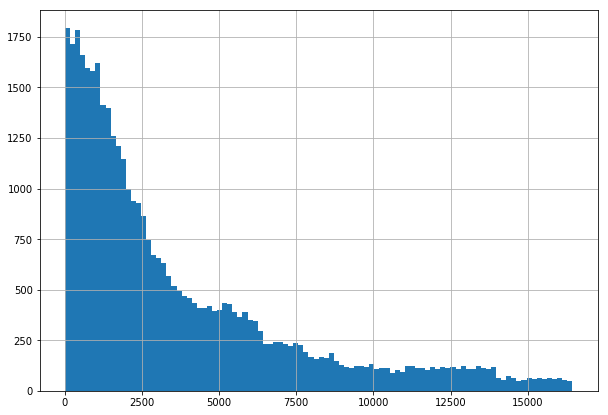

In [33]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

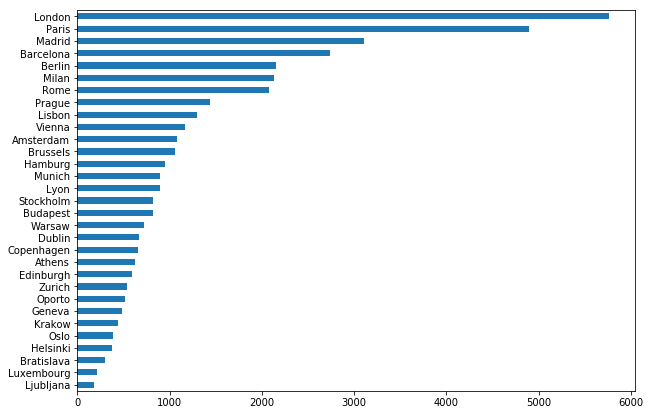

In [34]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

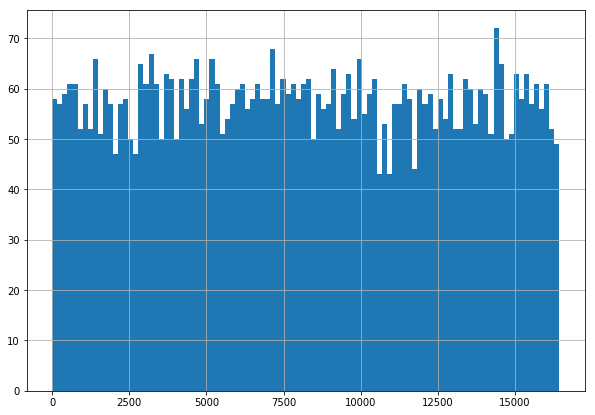

In [35]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

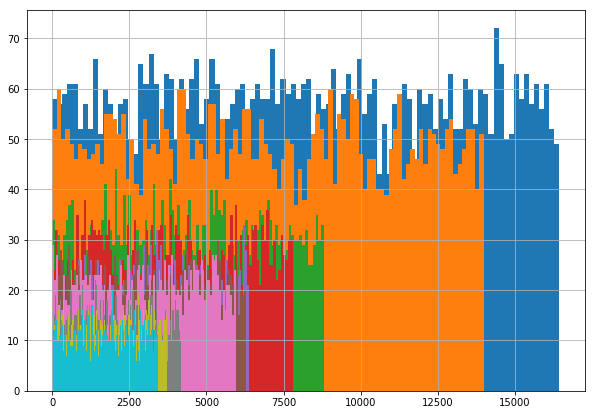

In [36]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

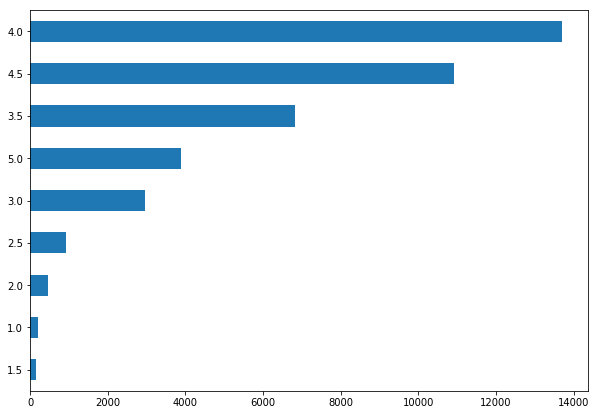

In [37]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

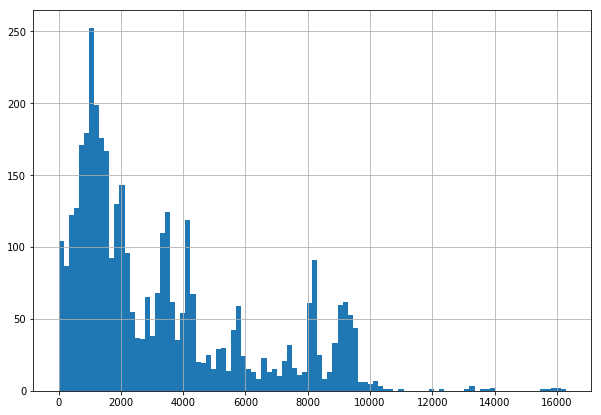

In [38]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

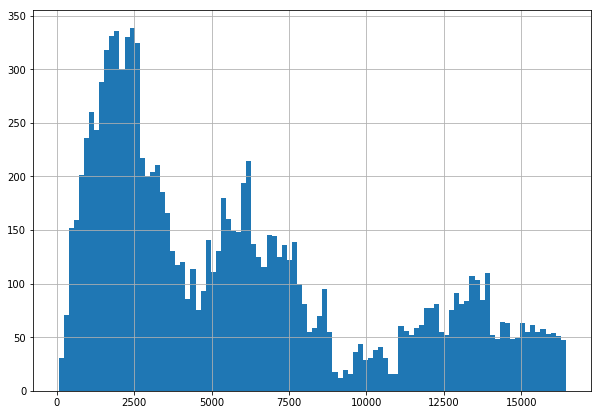

In [39]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

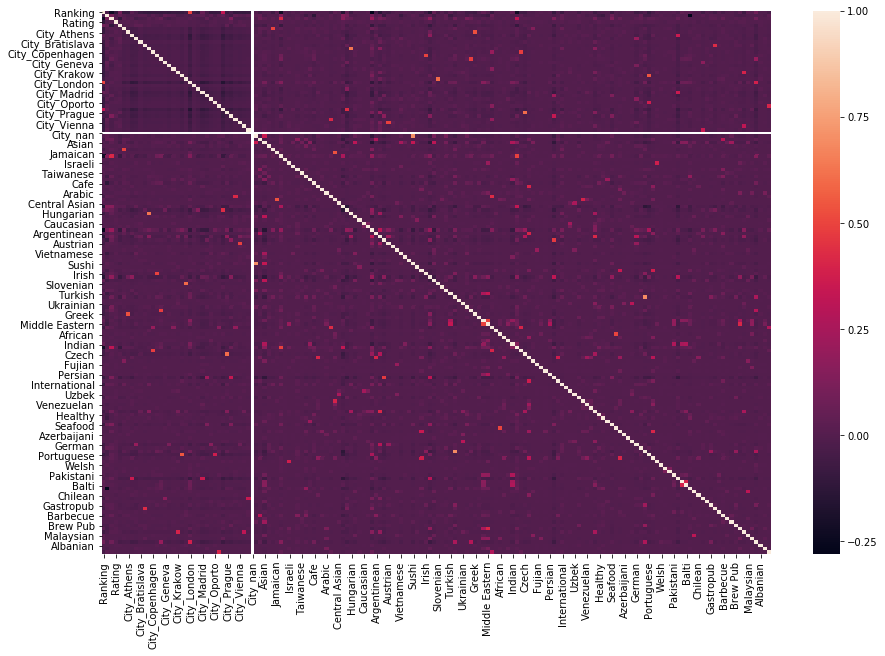

In [40]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [41]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [42]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
        
    
    
    
    ### Разбивка Cuisine Style на признаки ###
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: "['Vegetarian Friendly']" if pd.isna(x) else x)
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: decode(x) if not pd.isna(x) else [])
    all_cuisines = set()
    
    for i in df_output['Cuisine Style']:
        all_cuisines.update(i)
        
    cuisines = pd.DataFrame(df_output[['Cuisine Style']])
    
    for style in list(all_cuisines):
        cuisines[style] = cuisines['Cuisine Style'].apply(lambda x: 1 if style in x else 0)
        
    del cuisines['Cuisine Style']
    df_output = pd.concat([df_output, cuisines], axis=1)
    
    ### Обработка Price Range ###
    df_output['Price Range'] = df_output['Price Range'].apply(lambda x: '$$ - $$$' if pd.isnull(x) else x)
    price_range = {'$' : 1, '$$ - $$$': 2, '$$$$': 3}
    df_output['Price Range'] = df_output['Price Range'].map(price_range)
    df_output = pd.get_dummies(df_output, columns=['Price Range',], dummy_na=True)
    


    
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [43]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,Japanese,Steakhouse,Asian,Diner,Dutch,Jamaican,Gluten Free Options,Xinjiang,Israeli,Cambodian,Grill,Taiwanese,American,Nepali,Cafe,Peruvian,Southwestern,Arabic,Swedish,Caribbean,Central Asian,Vegetarian Friendly,French,Hungarian,Thai,Hawaiian,Caucasian,Armenian,European,Argentinean,Central European,Pizza,Austrian,Croatian,Minority Chinese,Vietnamese,Sri Lankan,Romanian,Sushi,Polynesian,Mexican,Irish,Mediterranean,Chinese,Slovenian,Cajun & Creole,Fusion,Turkish,Bar,Canadian,Ukrainian,Soups,Scottish,Greek,Delicatessen,Halal,Middle Eastern,Scandinavian,Latvian,African,Colombian,Afghani,Indian,Vegan Options,Danish,Czech,South American,Indonesian,Fujian,Tunisian,Salvadoran,Persian,Italian,Brazilian,International,Yunnan,Georgian,Uzbek,Wine Bar,Cuban,Venezuelan,Ecuadorean,Eastern European,Healthy,Street Food,Tibetan,Seafood,Ethiopian,Central American,Azerbaijani,Burmese,Russian,German,Contemporary,Pub,Portuguese,Latin,Kosher,Welsh,Australian,New Zealand,Pakistani,Spanish,Bangladeshi,Balti,Fast Food,Singaporean,Chilean,Swiss,Mongolian,Gastropub,Belgian,Native American,Barbecue,Filipino,Korean,Brew Pub,Lebanese,Polish,Malaysian,Moroccan,British,Albanian,Egyptian,Norwegian,Price Range_1.0,Price Range_2.0,Price Range_3.0,Price Range_nan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
44843,933.0,0.0,1,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
26507,8460.0,11.0,1,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15172,14795.0,0.0,1,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30882,345.0,109.0,1,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4211,2221.0,12.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28699,7399.0,18.0,1,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22679,1779.0,35.0,1,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

In [44]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 165 entries, Ranking to City_nan
dtypes: float64(3), int64(126), uint8(36)
memory usage: 50.9 MB


In [45]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [46]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [47]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 164), (40000, 164), (40000, 163), (32000, 163), (8000, 163))

# Model 
Сам ML

In [48]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [49]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [50]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20989624999999998


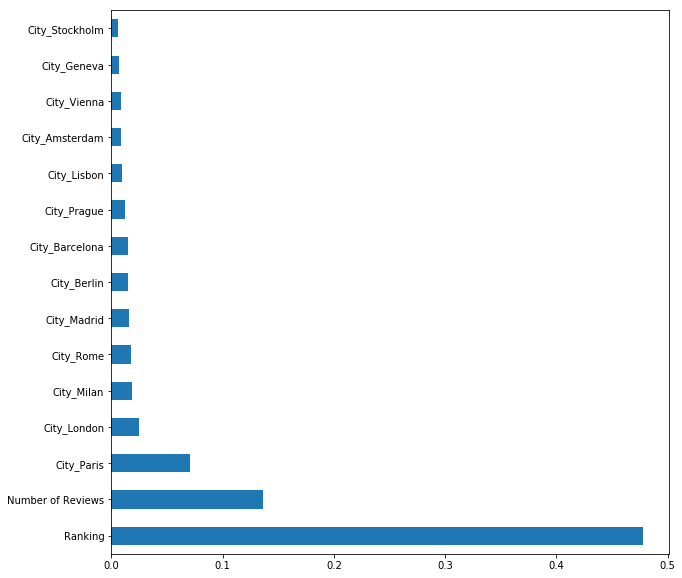

In [52]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [53]:
test_data.sample(10)
test_data

,Ranking,Number of Reviews,Rating,Japanese,Steakhouse,Asian,Diner,Dutch,Jamaican,Gluten Free Options,Xinjiang,Israeli,Cambodian,Grill,Taiwanese,American,Nepali,Cafe,Peruvian,Southwestern,Arabic,Swedish,Caribbean,Central Asian,Vegetarian Friendly,French,Hungarian,Thai,Hawaiian,Caucasian,Armenian,European,Argentinean,Central European,Pizza,Austrian,Croatian,Minority Chinese,Vietnamese,Sri Lankan,Romanian,Sushi,Polynesian,Mexican,Irish,Mediterranean,Chinese,Slovenian,Cajun & Creole,Fusion,Turkish,Bar,Canadian,Ukrainian,Soups,Scottish,Greek,Delicatessen,Halal,Middle Eastern,Scandinavian,Latvian,African,Colombian,Afghani,Indian,Vegan Options,Danish,Czech,South American,Indonesian,Fujian,Tunisian,Salvadoran,Persian,Italian,Brazilian,International,Yunnan,Georgian,Uzbek,Wine Bar,Cuban,Venezuelan,Ecuadorean,Eastern European,Healthy,Street Food,Tibetan,Seafood,Ethiopian,Central American,Azerbaijani,Burmese,Russian,German,Contemporary,Pub,Portuguese,Latin,Kosher,Welsh,Australian,New Zealand,Pakistani,Spanish,Bangladeshi,Balti,Fast Food,Singaporean,Chilean,Swiss,Mongolian,Gastropub,Belgian,Native American,Barbecue,Filipino,Korean,Brew Pub,Lebanese,Polish,Malaysian,Moroccan,British,Albanian,Egyptian,Norwegian,Price Range_1.0,Price Range_2.0,Price Range_3.0,Price Range_nan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,12963.0,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,106.0,97.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,810.0,28.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1669.0,202.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37.0,162.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [54]:
test_data = test_data.drop(['Rating'], axis=1)

In [55]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [56]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [57]:
predict_submission

array([2.995, 4.305, 4.475, ..., 3.005, 4.495, 4.305])

In [58]:
data.Restaurant_id.value_counts()

id_633      19
id_436      19
id_871      19
id_227      19
id_585      18
            ..
id_11668     1
id_13875     1
id_16093     1
id_10908     1
id_13098     1
Name: Restaurant_id, Length: 13094, dtype: int64

In [59]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.995
1,id_1,4.305
2,id_2,4.475
3,id_3,4.345
4,id_4,4.455
5,id_5,4.715
6,id_6,1.940
7,id_7,2.615
8,id_8,4.130
9,id_9,4.720


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
